In [10]:
import os
import logging
import pymc4 as pm
import numpy as np
import pandas as pd
import tensorflow as tf

from stellr import Model, Emulator
from stellr.models import offset_beta, offset_lognormal, offset_normal, metallicity, luminosity

In [11]:
class Population(Model):

    _vars = {
        'population': [
            'dydz', 'yp', 'sigma_yi', 'mlt',
            {
                'stars': [
                    'f_evol', 'mass', 'yi', 'zi', 'mhi', 'age', 'teff', 'rad', 'lum', 'dnu', 'mhs'
                ]
            }
        ]
    }

    def _init_model(self):

        emulator = Emulator('Lyttle20')
        # TODO: the same as in Stars

        if isinstance(self.observed['population/stars'], pd.DataFrame):
            observed = self.observed['population/stars']
        else:
            observed = pd.DataFrame(self.observed['population/stars'])
        
        n = len(observed)
        observed = observed.drop(columns='name', errors='ignore').astype(np.float32)
        mask = ~np.isnan(observed)

        @pm.model
        def stars(dydz=1.5, yp=0.247, sigma_yi=0.01, mlt=2.0):

            theta = {}

            theta['f_evol'] = yield offset_beta(1.2, 1.2, 
                emulator.x_limits['f_evol']['start'], emulator.x_limits['f_evol']['end'], 
                name='f_evol', batch_stack=n)
            
            theta['mass'] = yield offset_beta(1.2, 1.2, 
                emulator.x_limits['mass']['start'], emulator.x_limits['mass']['end'], 
                name='mass', batch_stack=n)

            theta['zi'] = yield offset_beta(1.2, 1.2, 
                emulator.x_limits['zi']['start'], emulator.x_limits['zi']['end'], 
                name='zi', batch_stack=n)

            mu_y = yp + dydz * theta['zi']
            theta['yi'] = yield offset_normal(mu_y, sigma_yi, name='yi', batch_stack=n)

            inputs = tf.stack([theta['f_evol'], theta['mass'], mlt*tf.ones(n), theta['yi'], theta['zi']], axis=-1)
            outputs = emulator(inputs)

            theta['log_age'] = yield pm.Deterministic('log_age', outputs[:, 0])
            theta['teff'] = yield pm.Deterministic('teff', outputs[:, 1])
            theta['rad'] = yield pm.Deterministic('rad', outputs[:, 2])
            theta['dnu'] = yield pm.Deterministic('dnu', outputs[:, 3])
            theta['mhs'] = yield pm.Deterministic('mhs', outputs[:, 4])

            theta['mhi'] = yield pm.Deterministic('mhi', metallicity(theta['yi'], theta['zi']))
            theta['age'] = yield pm.Deterministic('age', 10**theta['log_age'])
            theta['lum'] = yield pm.Deterministic('lum', luminosity(theta['rad'], theta['teff']))
            
            for key, value in theta.items():
                if key in observed.keys():

                    yield pm.Normal(f'{key}_obs', tf.boolean_mask(value, mask[key]), 
                        observed.loc[mask[key], f'{key}_err'], 
                        observed=observed.loc[mask[key], key])

        @pm.model
        def population():
            phi = {}

            phi['dydz'] = yield offset_beta(1.2, 1.2, 0.0, 4.0, name='dydz')
            phi['yp'] = yield offset_normal(0.247, 0.001, name='yp')
            phi['sigma_yi'] = yield offset_lognormal(0.01, 1.0, name='sigma_yi')

            phi['mlt'] = yield offset_beta(1.2, 1.2, 
                emulator.x_limits['mlt']['start'], emulator.x_limits['mlt']['end'], 
                name='mlt')

            for key, value in phi.items():
                if key in self.observed['population'].keys():
                    yield pm.Normal(f'{key}_obs', value, self.observed['population'][f'{key}_err'], 
                                    observed=self.observed['population'][key])
            
            yield stars(**phi)

        return population()

In [3]:
data = pd.read_csv(f'../../data/tracks/test_stars/test_stars_obs.csv')
data.head()

,index,teff,lum,mhs,logg,dnu,teff_err,lum_err,mhs_err,logg_err,dnu_err
0,0,5509.868287,0.455461,0.048007,4.548031,168.551764,114.277805,0.015823,0.072604,0.019638,0.933
1,1,5132.860162,0.447037,0.120842,4.475545,162.050913,113.587711,0.016370,0.072604,0.019638,0.933
2,2,4950.043140,0.316783,0.354314,4.560913,177.591451,107.523969,0.011491,0.072604,0.019638,0.933
3,3,5541.041366,0.559689,0.060892,4.572558,163.088949,119.257352,0.019744,0.072604,0.019638,0.933
4,4,5332.712767,0.574903,-0.022662,4.467451,154.153583,116.408089,0.019259,0.072604,0.019638,0.933


In [4]:
data['name'] = data['index'].astype(str)
data.head()

,index,teff,lum,mhs,logg,dnu,teff_err,lum_err,mhs_err,logg_err,dnu_err,name
0,0,5509.868287,0.455461,0.048007,4.548031,168.551764,114.277805,0.015823,0.072604,0.019638,0.933,0
1,1,5132.860162,0.447037,0.120842,4.475545,162.050913,113.587711,0.016370,0.072604,0.019638,0.933,1
2,2,4950.043140,0.316783,0.354314,4.560913,177.591451,107.523969,0.011491,0.072604,0.019638,0.933,2
3,3,5541.041366,0.559689,0.060892,4.572558,163.088949,119.257352,0.019744,0.072604,0.019638,0.933,3
4,4,5332.712767,0.574903,-0.022662,4.467451,154.153583,116.408089,0.019259,0.072604,0.019638,0.933,4


In [5]:
observed = {
    'population/stars': data
}

In [12]:
pop = Population(name=f'test_max_pool', path='population_results', observed=observed)

logging.basicConfig(
    format='%(asctime)s: %(levelname)s: %(message)s', 
    filename=os.path.join(pop.savedir, 'pop.log'), 
    level=logging.INFO,
)

In [13]:
sample_kwargs = {
    'num_samples': 2000,
    'burn_in': 2000,
    'num_chains': 10,
    'xla': True,
    'adaptation_kwargs': {
        'target_accept_prob': 0.98,
    },
}

In [14]:
%%time
pop.fit(sample_kwargs=sample_kwargs)

2020-08-24 14:21:19,210 stellr.optimizer INFO     Fitting population for 2000 samples across 10 chains with 2000 burn in steps per chain.
2020-08-24 15:05:04,839 stellr.optimizer WARNING  The number of effective samples was less than 10% for 448 parameters.
2020-08-24 15:05:04,846 stellr.optimizer WARNING  The number of effective samples was less than 25% for 715 parameters.


CPU times: user 42min 46s, sys: 1min 19s, total: 44min 6s
Wall time: 44min 3s


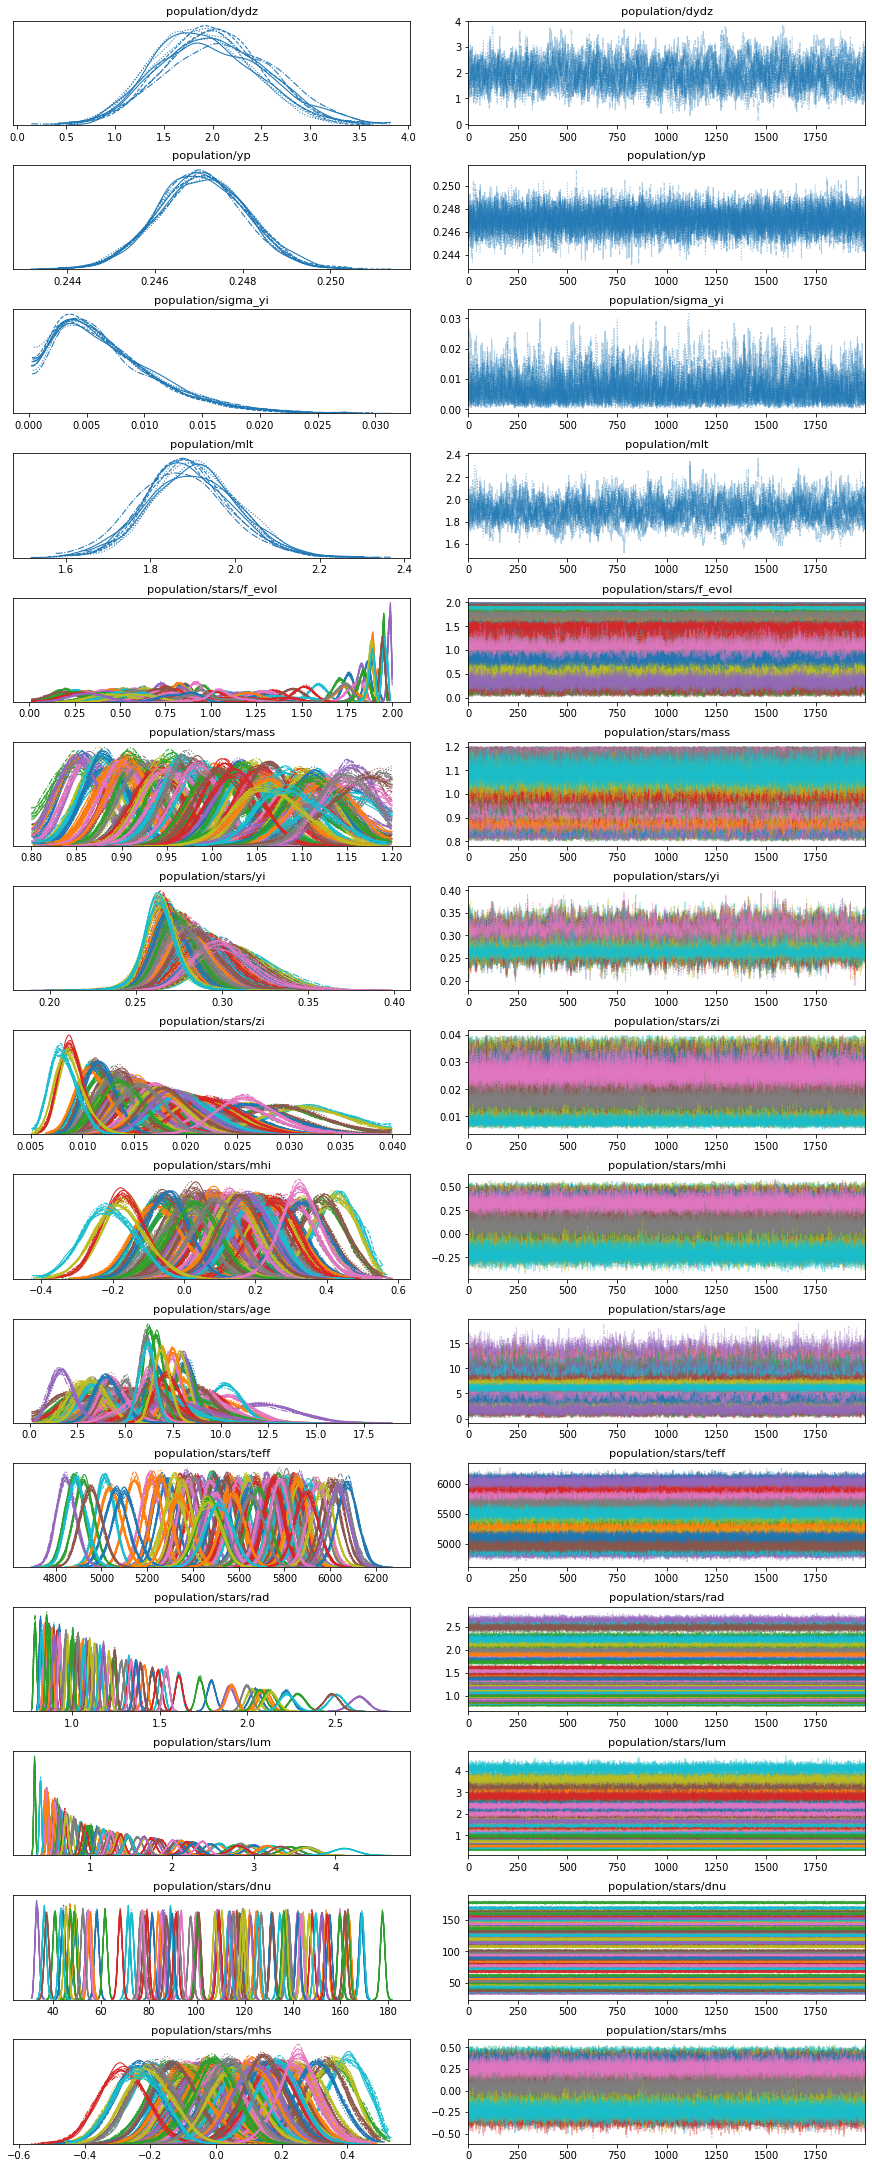

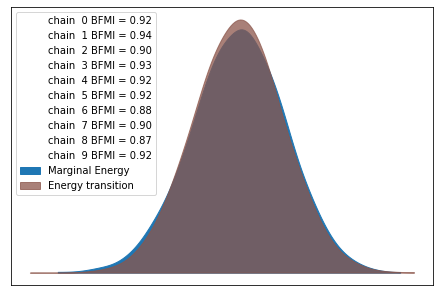

In [15]:
pop.plot_diagnostics(save=True);

In [16]:
pop.plot_corners(save=True)